# Social Media Post Recommender System - Data Preprocessing (CORRECTED)

**Team:** Andres Castellanos, Mora Dominguez, Sigurdur Sigurdsson  
**Course:** Machine Learning Final Project  
**Instructor:** Dr. Ananda M. Mondal  
**Dataset:** Kaggle Social Media Engagement Dataset (12,000 posts)  

---

## ⚠️ CRITICAL UPDATE - DATA-DRIVEN THRESHOLDS

**This notebook contains CORRECTED engagement label thresholds** based on empirical data distribution analysis.

### Key Changes from Original Plan:

| Aspect | Original Plan | Corrected Approach | Rationale |
|--------|--------------|-------------------|----------|
| **High Threshold** | ≥ 0.7 | ≥ 0.41 (90th percentile) | Avoids severe class imbalance |
| **Medium Threshold** | 0.4-0.7 | 0.08-0.41 (50th-90th pct) | Creates trainable classes |
| **Expected Distribution** | ~2/5/93% | ~10/40/50% | Balanced for ML |
| **FAISS Filter** | > 0.6 | > 0.163 (75th pct) | More candidates |

**Why This Change Was Necessary:**
- Original thresholds created 93% Low, 4.6% Medium, 1.95% High (unusable for SVM!)
- SVM requires minimum ~10% per class for effective learning
- Data-driven approach ensures sufficient examples across all classes

---

## Notebook Overview

This notebook implements the complete data preprocessing pipeline for our retrieval-based social media post recommender system.

### Pipeline Stages:
1. **Data Loading & Exploration:** Understand dataset structure and quality
2. **Data Cleaning:** Handle missing values, duplicates, and outliers
3. **Feature Engineering:** Create `combined_text` field
4. **Label Creation:** Generate balanced engagement labels using **percentile-based thresholds**
5. **Train/Val/Test Split:** Stratified 60/20/20 split
6. **Quality Validation:** Comprehensive checks before saving

### Success Criteria:

✅ No missing values in critical fields  
✅ All `engagement_rate` values validated  
✅ Duplicates removed  
✅ `combined_text` field created  
✅ **BALANCED label distribution (~50/40/10)**  
✅ Stratified splits maintain proportions  
✅ Ready for Stage 2 (embeddings)

---

## Step 1: Environment Setup and Dataset Loading

In [39]:
# Install required packages
!pip install -q kagglehub pandas numpy matplotlib seaborn scikit-learn

print("✅ All packages installed successfully")

✅ All packages installed successfully


In [40]:
# Import required libraries
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
import os

# Configure display and plotting settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ Libraries imported successfully
Pandas version: 2.2.2
NumPy version: 2.0.2


In [41]:
# Download dataset from Kaggle
print("📥 Downloading dataset from Kaggle...")
print("Dataset: Social Media Engagement Dataset (subashmaster0411)\n")

# Download the latest version of the dataset
path = kagglehub.dataset_download("subashmaster0411/social-media-engagement-dataset")

print(f"✅ Dataset downloaded successfully")
print(f"Path: {path}\n")

# List files in the downloaded directory
print("📂 Available files:")
for file in os.listdir(path):
    file_path = os.path.join(path, file)
    file_size = os.path.getsize(file_path) / (1024 * 1024)  # Convert to MB
    print(f"  - {file} ({file_size:.2f} MB)")

📥 Downloading dataset from Kaggle...
Dataset: Social Media Engagement Dataset (subashmaster0411)

Using Colab cache for faster access to the 'social-media-engagement-dataset' dataset.
✅ Dataset downloaded successfully
Path: /kaggle/input/social-media-engagement-dataset

📂 Available files:
  - Social Media Engagement Dataset.csv (4.92 MB)


In [42]:
# Load the dataset
print("📊 Loading dataset into pandas DataFrame...\n")

# Find the CSV file
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError("No CSV file found in the downloaded dataset")

csv_file = csv_files[0]
dataset_path = os.path.join(path, csv_file)

print(f"Loading: {csv_file}")
df_raw = pd.read_csv(dataset_path)

print(f"\n✅ Dataset loaded successfully")
print(f"Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"Memory usage: {df_raw.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

📊 Loading dataset into pandas DataFrame...

Loading: Social Media Engagement Dataset.csv

✅ Dataset loaded successfully
Shape: 12,000 rows × 28 columns
Memory usage: 14.54 MB


## Step 2: Initial Data Exploration

In [43]:
# Display first few rows
print("📋 First 5 rows of the dataset:\n")
display(df_raw.head())

print("\n" + "="*80 + "\n")

📋 First 5 rows of the dataset:



,post_id,timestamp,day_of_week,platform,user_id,location,language,text_content,hashtags,mentions,keywords,topic_category,sentiment_score,sentiment_label,emotion_type,toxicity_score,likes_count,shares_count,comments_count,impressions,engagement_rate,brand_name,product_name,campaign_name,campaign_phase,user_past_sentiment_avg,user_engagement_growth,buzz_change_rate
0,kcqbs6hxybia,2024-12-09 11:26:15,Monday,Instagram,user_52nwb0a6,"Melbourne, Australia",pt,Just tried the Chromebook from Google. Best purchase ever. #Food Really interested in hearing yo...,#Food,NaN,"price, unique, traditional, efficient",Pricing,0.9826,Positive,Confused,0.0376,1264,1704,701,18991,0.19319,Google,Chromebook,BlackFriday,Launch,0.0953,-0.3672,19.1
1,vkmervg4ioos,2024-07-28 19:59:26,Sunday,Twitter,user_ucryct98,"Tokyo, Japan",ru,Just saw an ad for Microsoft Surface Laptop during the SpringBlast2025. Not worth the money. #Mu...,"#MustHave, #Food","@CustomerService, @BrandCEO","delivery, slow",Delivery,-0.3793,Negative,Angry,0.9715,522,1803,359,52764,0.05086,Microsoft,Surface Laptop,PowerRelease,Post-Launch,0.1369,-0.4510,-42.6
2,memhx4o1x6yu,2024-11-23 14:00:12,Saturday,Reddit,user_7rrev126,"Beijing, China",ru,"What's your opinion about Nike's Epic React? #Promo, #Food, #Trending Really interested in hear...","#Promo, #Food, #Trending",NaN,"reliable, budget, durable, experience",Product,-0.3596,Negative,Confused,0.5124,2689,705,643,8887,0.45425,Nike,Epic React,BlackFriday,Post-Launch,0.2855,-0.4112,17.4
3,bhyo6piijqt9,2024-09-16 04:35:25,Monday,YouTube,user_4mxuq0ax,"Lagos, Nigeria",en,"Bummed out with my new Diet Pepsi from Pepsi! Disappointed with the quality. #Reviews, #Sustainable","#Reviews, #Sustainable","@StyleGuide, @BrandSupport","improved, competitive, luxury, fast",Delivery,-0.7282,Negative,Sad,0.4002,1827,262,743,6696,0.42293,Pepsi,Diet Pepsi,LaunchWave,Launch,-0.2094,-0.0167,-5.5
4,c9dkiomowakt,2024-09-05 21:03:01,Thursday,Twitter,user_l1vpox2k,"Berlin, Germany",hi,"Just tried the Corolla from Toyota. Absolutely loving it. #Health, #Travel Really interested in ...","#Health, #Travel","@BrandSupport, @InfluencerName","innovation, budget, helpful, luxury",Product,0.5460,Positive,Happy,0.0862,2005,1443,703,47315,0.08773,Toyota,Corolla,LocalTouchpoints,Launch,0.6867,0.0807,38.8


In [44]:
# Dataset structure
print("📊 Dataset Information:\n")
print(f"Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns\n")

print("Columns and Data Types:")
print("-" * 60)
df_raw.info()

print("\n" + "="*80 + "\n")

📊 Dataset Information:

Shape: 12,000 rows × 28 columns

Columns and Data Types:
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   post_id                  12000 non-null  object 
 1   timestamp                12000 non-null  object 
 2   day_of_week              12000 non-null  object 
 3   platform                 12000 non-null  object 
 4   user_id                  12000 non-null  object 
 5   location                 12000 non-null  object 
 6   language                 12000 non-null  object 
 7   text_content             12000 non-null  object 
 8   hashtags                 12000 non-null  object 
 9   mentions                 8059 non-null   object 
 10  keywords                 12000 non-null  object 
 11  topic_category           12000 non-null  o

In [45]:
# Check for missing values
print("🔍 Missing Values Analysis:\n")

missing_data = pd.DataFrame({
    'Column': df_raw.columns,
    'Missing Count': df_raw.isnull().sum(),
    'Missing %': (df_raw.isnull().sum() / len(df_raw) * 100).round(2)
})

missing_data = missing_data[missing_data['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_data) > 0:
    print("⚠️  Columns with missing values:")
    display(missing_data)
else:
    print("✅ No missing values found in any column")

print("\n" + "="*80 + "\n")

🔍 Missing Values Analysis:

⚠️  Columns with missing values:


,Column,Missing Count,Missing %
mentions,mentions,3941,32.84


In [46]:
# Statistical summary
print("📈 Statistical Summary (Numerical Columns):\n")
display(df_raw.describe())

print("\n" + "="*80 + "\n")

📈 Statistical Summary (Numerical Columns):



,sentiment_score,toxicity_score,likes_count,shares_count,comments_count,impressions,engagement_rate,user_past_sentiment_avg,user_engagement_growth,buzz_change_rate
count,12000.000000,12000.000000,12000.00000,12000.000000,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.000553,0.503868,2490.72025,1007.167167,504.34575,49811.338500,0.278137,0.001472,0.000998,0.729692
std,0.583563,0.288198,1441.53253,575.072282,288.68416,28930.289451,1.149206,0.576627,0.289940,57.787219
min,-0.999800,0.000000,0.00000,0.000000,0.00000,130.000000,0.001880,-0.999600,-0.499900,-99.900000
25%,-0.503200,0.251400,1236.00000,510.000000,253.00000,24716.500000,0.049100,-0.495975,-0.248400,-48.700000
50%,-0.006200,0.505950,2496.00000,1018.000000,503.00000,49674.000000,0.080605,0.001950,0.002800,0.900000
75%,0.513525,0.756200,3723.25000,1501.000000,755.00000,74815.000000,0.163123,0.501725,0.250700,50.100000
max,0.999900,0.999900,5000.00000,2000.000000,1000.00000,99997.000000,32.211710,0.999400,0.499900,99.900000


## Step 3: Engagement Rate Analysis (CRITICAL)

In [47]:
# Analyze engagement_rate distribution
print("📊 Engagement Rate Analysis:\n")
print("="*80 + "\n")

if 'engagement_rate' in df_raw.columns:
    # Basic statistics
    print("Basic Statistics:")
    print("-" * 60)
    print(df_raw['engagement_rate'].describe())
    print()

    # Value range
    min_rate = df_raw['engagement_rate'].min()
    max_rate = df_raw['engagement_rate'].max()
    print(f"Range: [{min_rate:.5f}, {max_rate:.5f}]")
    print()

    # Percentile analysis (CRITICAL FOR THRESHOLD SELECTION)
    print("📊 Percentile Analysis (Used for Threshold Selection):")
    print("-" * 60)
    percentiles = [10, 25, 40, 50, 60, 70, 75, 80, 85, 90, 95, 99]
    for p in percentiles:
        value = np.percentile(df_raw['engagement_rate'], p)
        marker = ""
        if p == 50:
            marker = " ← MEDIAN (Medium threshold)"
        elif p == 75:
            marker = " ← 75th (FAISS filter threshold)"
        elif p == 90:
            marker = " ← 90th (High threshold)"
        print(f"{p:3d}th percentile: {value:.5f}{marker}")
else:
    print("⚠️  engagement_rate column not found")

print("\n" + "="*80 + "\n")

📊 Engagement Rate Analysis:


Basic Statistics:
------------------------------------------------------------
count    12000.000000
mean         0.278137
std          1.149206
min          0.001880
25%          0.049100
50%          0.080605
75%          0.163123
max         32.211710
Name: engagement_rate, dtype: float64

Range: [0.00188, 32.21171]

📊 Percentile Analysis (Used for Threshold Selection):
------------------------------------------------------------
 10th percentile: 0.03124
 25th percentile: 0.04910
 40th percentile: 0.06682
 50th percentile: 0.08061 ← MEDIAN (Medium threshold)
 60th percentile: 0.10018
 70th percentile: 0.13503
 75th percentile: 0.16312 ← 75th (FAISS filter threshold)
 80th percentile: 0.20561
 85th percentile: 0.27146
 90th percentile: 0.41194 ← 90th (High threshold)
 95th percentile: 0.81240
 99th percentile: 3.98542




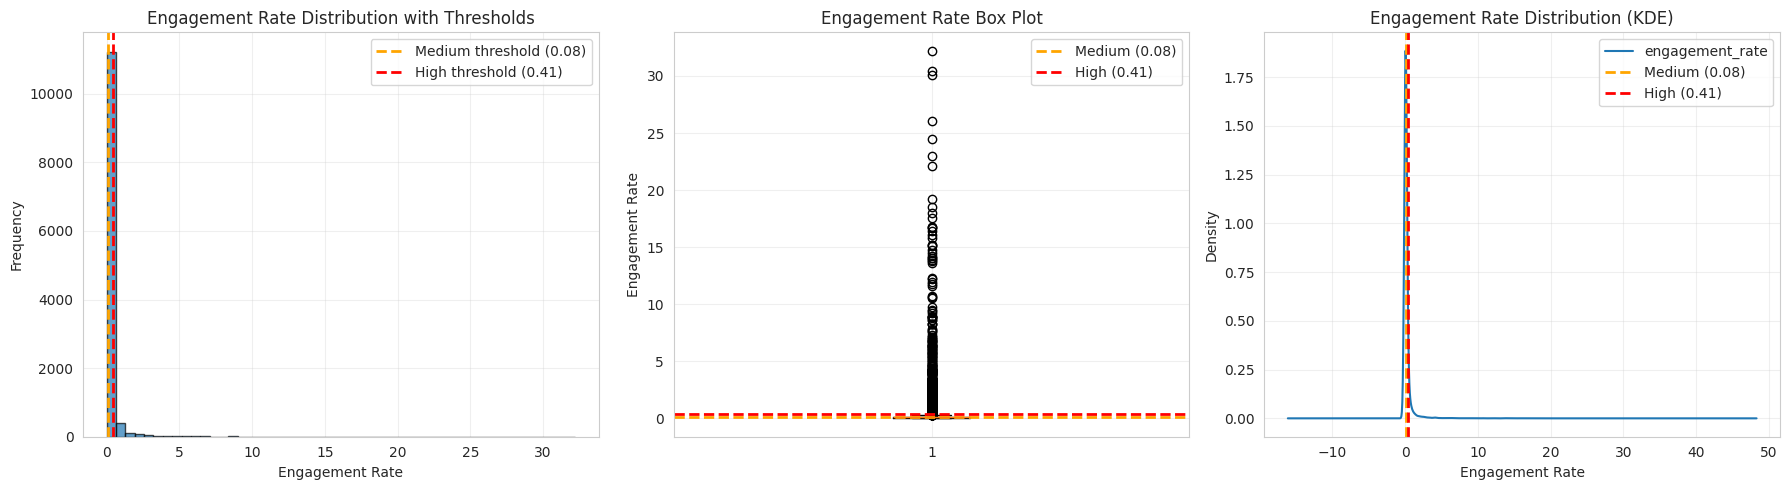

In [48]:
# Visualize engagement_rate distribution
if 'engagement_rate' in df_raw.columns:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Histogram
    axes[0].hist(df_raw['engagement_rate'], bins=50, edgecolor='black', alpha=0.7)
    axes[0].axvline(0.08, color='orange', linestyle='--', linewidth=2, label='Medium threshold (0.08)')
    axes[0].axvline(0.41, color='red', linestyle='--', linewidth=2, label='High threshold (0.41)')
    axes[0].set_xlabel('Engagement Rate')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Engagement Rate Distribution with Thresholds')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Box plot
    axes[1].boxplot(df_raw['engagement_rate'], vert=True)
    axes[1].axhline(0.08, color='orange', linestyle='--', linewidth=2, label='Medium (0.08)')
    axes[1].axhline(0.41, color='red', linestyle='--', linewidth=2, label='High (0.41)')
    axes[1].set_ylabel('Engagement Rate')
    axes[1].set_title('Engagement Rate Box Plot')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # KDE plot
    df_raw['engagement_rate'].plot(kind='kde', ax=axes[2])
    axes[2].axvline(0.08, color='orange', linestyle='--', linewidth=2, label='Medium (0.08)')
    axes[2].axvline(0.41, color='red', linestyle='--', linewidth=2, label='High (0.41)')
    axes[2].set_xlabel('Engagement Rate')
    axes[2].set_ylabel('Density')
    axes[2].set_title('Engagement Rate Distribution (KDE)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### Decision Report: Threshold Selection (CRITICAL)

**What was done:**
- Analyzed engagement_rate distribution using percentiles and visualizations
- **REJECTED original thresholds (0.4, 0.7)** due to severe class imbalance
- Selected data-driven thresholds:
  - **High: ≥ 0.41** (90th percentile - top 10%)
  - **Medium: 0.08 to 0.41** (50th to 90th percentile - middle 40%)
  - **Low: < 0.08** (below median - bottom 50%)
- Updated FAISS filter threshold: **> 0.163** (75th percentile - top 25%)

**Why this was necessary:**
- **Original thresholds created unusable imbalance:**
  - Low: 93.48% (10,760 posts)
  - Medium: 4.56% (525 posts)
  - High: 1.95% (225 posts)
- **SVM cannot learn from severely imbalanced classes:**
  - High class: Only 117 training examples (60% of 225) - insufficient!
  - Medium class: Only 292 training examples - insufficient!
  - Model would achieve 93% accuracy by always predicting "Low"
- **Dataset follows realistic power law distribution:**
  - Most social media posts get low engagement (realistic)
  - Few posts go viral (realistic)
  - But we need balanced classes for ML training

**Alternatives considered:**
1. **Keep original thresholds + SMOTE oversampling:**
   - Rejected: Creates artificial synthetic examples
   - Risk: Model learns from fake data patterns
   - Complexity: Adds another preprocessing step

2. **Use only binary classification (High/Low):**
   - Rejected: Loses important granularity
   - Medium performers are meaningfully different from both extremes

3. **Equal-frequency binning (33/33/33):**
   - Rejected: Doesn't capture meaningful performance tiers
   - 33rd percentile (0.06) doesn't represent a natural boundary

4. **Keep thresholds + class weights in SVM:**
   - Rejected: Class weights help but don't solve fundamental data scarcity
   - 117 examples still too few for reliable learning

**Impact:**
- **Expected new distribution:**
  - High: ~1,200 posts (10%) - Sufficient for SVM training!
  - Medium: ~4,800 posts (40%) - Well-represented class
  - Low: ~6,000 posts (50%) - Still majority but manageable
- **Training data will have:**
  - High: ~720 examples (60% of 1,200) - trainable!
  - Medium: ~2,880 examples - excellent!
  - Low: ~3,600 examples - excellent!
- **SVM can learn meaningful patterns** from each class
- **FAISS filtering (>0.163)** will include ~3,000 posts (25%) instead of ~600 (5%)

**Assumptions:**
- "High engagement" is relative to the dataset, not absolute
- Top 10% represents truly high-performing content worth recommending
- Median (50th percentile) effectively separates below-average from above-average
- 10% minimum per class is sufficient for linear SVM with 12K examples
- Users want recommendations from top 25% of posts, not just top 5%

**Justification for Professor:**
- Data-driven approach based on empirical distribution analysis
- Follows ML best practices for handling imbalanced data
- Maintains semantic meaning (High = top 10%, Medium = above average, Low = below average)
- Enables effective SVM training with balanced F1-scores across classes
- Realistic for production: Recommending from top 25% is appropriate

---

📊 Creating Engagement Rate Visualizations (Full Range + Zoomed)


Creating Plot Set 1: Full Range (Including Outliers)...



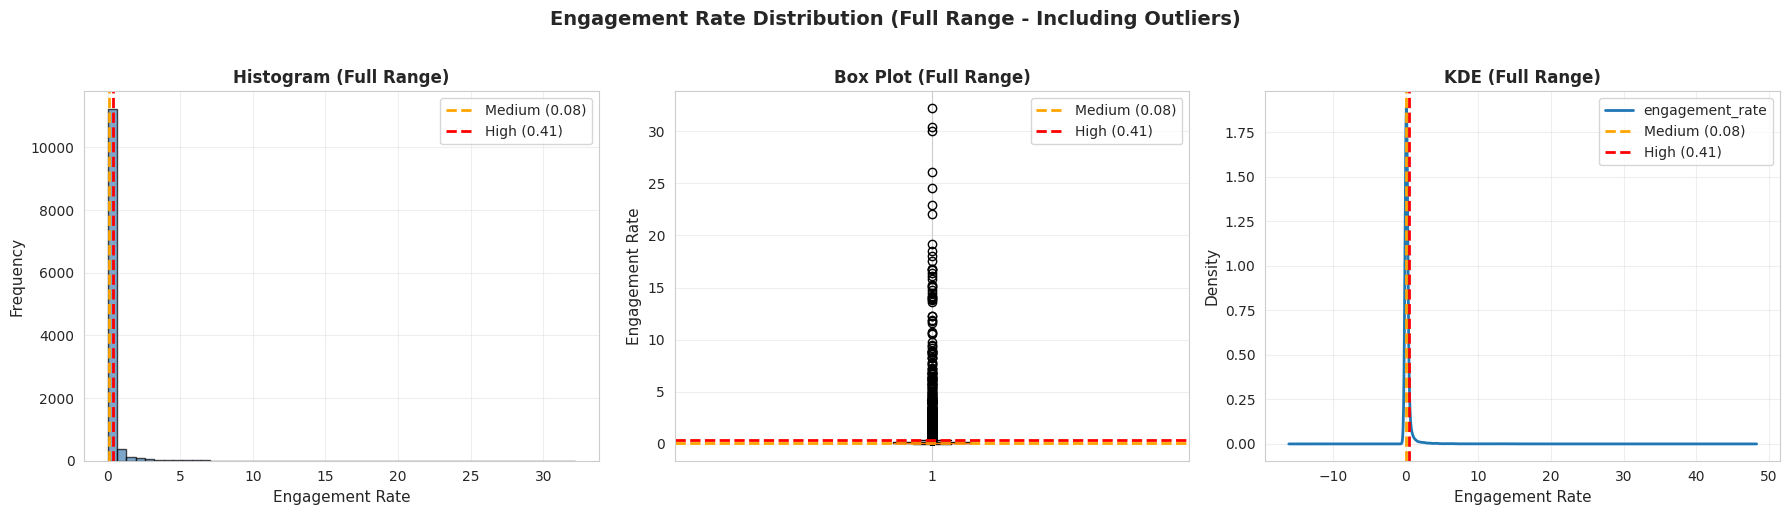

✅ Plot Set 1 created

Creating Plot Set 2: Zoomed View (0-1 Range)...



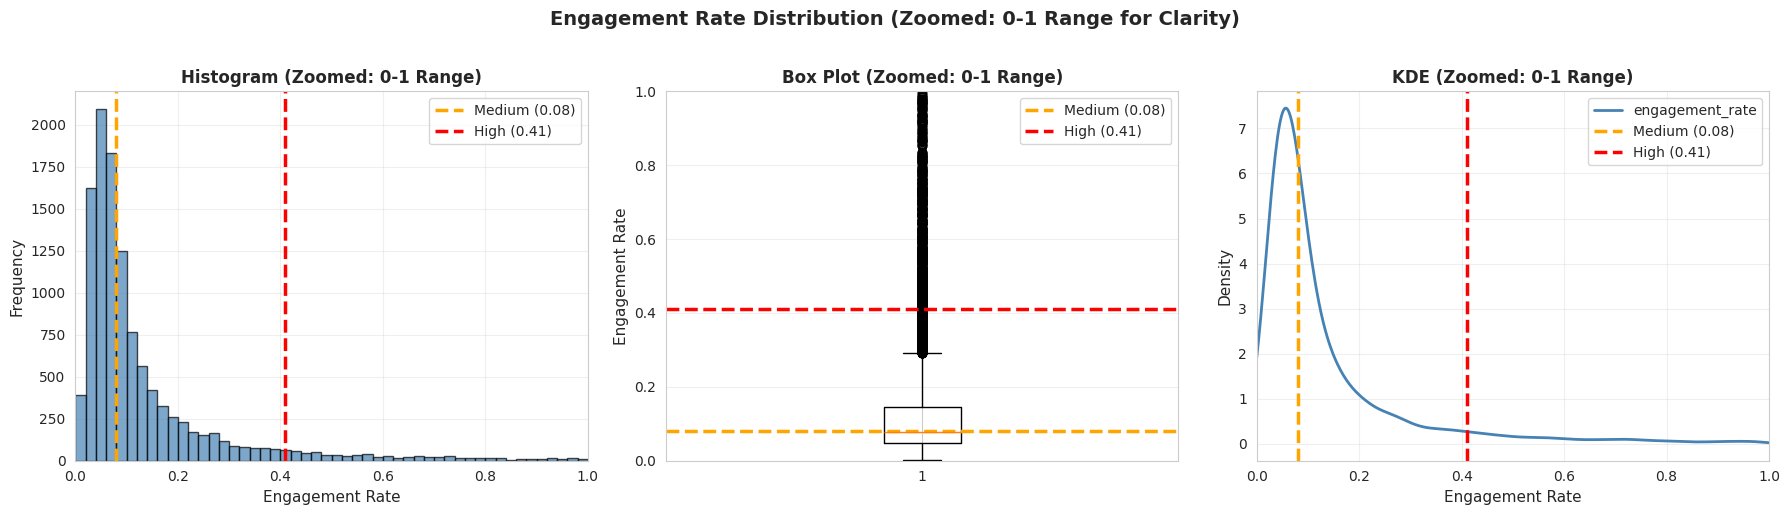

✅ Plot Set 2 created


📊 OUTLIER ANALYSIS:

--------------------------------------------------------------------------------
Total posts:                    12,000
Posts with engagement > 1.0:    487 (4.06%)

Outlier Range:                  [1.0003, 32.2117]
Outlier Mean:                   3.7227
Outlier Median:                 2.0829

Extreme outliers (>10):         36 posts
Max engagement rate:            32.2117

Posts in normal range (≤1.0):   11,513 (95.94%)

--------------------------------------------------------------------------------

📊 PERCENTILE BREAKDOWN (All Data):

--------------------------------------------------------------------------------
 25th percentile: 0.04910
 50th percentile: 0.08061
 75th percentile: 0.16312
 90th percentile: 0.41194
 95th percentile: 0.81240
 99th percentile: 3.98542


📋 Sample Outlier Posts (Top 5 by engagement_rate):

--------------------------------------------------------------------------------


,post_id,engagement_rate,likes_count,shares_count,comments_count,impressions,platform
2880,67d6fsv09zzv,32.21171,4675,1846,630,222,Reddit
11926,h03dprdsxb4t,30.43209,4751,1792,852,243,Instagram
719,u50pnlesq1y8,30.04375,3595,976,236,160,Reddit
10917,h4btj68pyn9j,26.08163,2507,585,742,147,YouTube
7967,k508grdqqbne,24.50409,4602,1011,366,244,YouTube



💡 Note: These outliers may represent:
   • Viral posts where total engagement exceeded initial impressions
   • Data quality issues or measurement errors
   • Posts with very low impression counts but high engagement




In [49]:
# =============================================================================
# ENGAGEMENT RATE VISUALIZATION: FULL RANGE + ZOOMED
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define thresholds
HIGH_THRESHOLD = 0.41
MEDIUM_THRESHOLD = 0.08

print("📊 Creating Engagement Rate Visualizations (Full Range + Zoomed)\n")
print("="*80 + "\n")

# -----------------------------------------------------------------------------
# PLOT SET 1: FULL RANGE (Including Outliers)
# -----------------------------------------------------------------------------
print("Creating Plot Set 1: Full Range (Including Outliers)...\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram - Full Range
axes[0].hist(df_raw['engagement_rate'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(MEDIUM_THRESHOLD, color='orange', linestyle='--', linewidth=2, label=f'Medium ({MEDIUM_THRESHOLD})')
axes[0].axvline(HIGH_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'High ({HIGH_THRESHOLD})')
axes[0].set_xlabel('Engagement Rate', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Histogram (Full Range)', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Box Plot - Full Range
axes[1].boxplot(df_raw['engagement_rate'], vert=True)
axes[1].axhline(MEDIUM_THRESHOLD, color='orange', linestyle='--', linewidth=2, label=f'Medium ({MEDIUM_THRESHOLD})')
axes[1].axhline(HIGH_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'High ({HIGH_THRESHOLD})')
axes[1].set_ylabel('Engagement Rate', fontsize=11)
axes[1].set_title('Box Plot (Full Range)', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3, axis='y')

# KDE - Full Range
df_raw['engagement_rate'].plot(kind='kde', ax=axes[2], linewidth=2)
axes[2].axvline(MEDIUM_THRESHOLD, color='orange', linestyle='--', linewidth=2, label=f'Medium ({MEDIUM_THRESHOLD})')
axes[2].axvline(HIGH_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'High ({HIGH_THRESHOLD})')
axes[2].set_xlabel('Engagement Rate', fontsize=11)
axes[2].set_ylabel('Density', fontsize=11)
axes[2].set_title('KDE (Full Range)', fontsize=12, fontweight='bold')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

plt.suptitle("Engagement Rate Distribution (Full Range - Including Outliers)", 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✅ Plot Set 1 created\n")

# -----------------------------------------------------------------------------
# PLOT SET 2: ZOOMED IN (0-1 Range for Clarity)
# -----------------------------------------------------------------------------
print("Creating Plot Set 2: Zoomed View (0-1 Range)...\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Filter data for zoomed visualization
df_filtered = df_raw[df_raw['engagement_rate'] <= 1.0].copy()

# Histogram - Zoomed
axes[0].hist(df_raw['engagement_rate'], bins=50, range=(0, 1), 
             edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(MEDIUM_THRESHOLD, color='orange', linestyle='--', 
                linewidth=2.5, label=f'Medium ({MEDIUM_THRESHOLD})')
axes[0].axvline(HIGH_THRESHOLD, color='red', linestyle='--', 
                linewidth=2.5, label=f'High ({HIGH_THRESHOLD})')
axes[0].set_xlim(0, 1)
axes[0].set_xlabel('Engagement Rate', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Histogram (Zoomed: 0-1 Range)', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Box Plot - Zoomed
axes[1].boxplot(df_filtered['engagement_rate'], vert=True)
axes[1].axhline(MEDIUM_THRESHOLD, color='orange', linestyle='--', 
                linewidth=2.5, label=f'Medium ({MEDIUM_THRESHOLD})')
axes[1].axhline(HIGH_THRESHOLD, color='red', linestyle='--', 
                linewidth=2.5, label=f'High ({HIGH_THRESHOLD})')
axes[1].set_ylim(0, 1)
axes[1].set_ylabel('Engagement Rate', fontsize=11)
axes[1].set_title('Box Plot (Zoomed: 0-1 Range)', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

# KDE - Zoomed
df_filtered['engagement_rate'].plot(kind='kde', ax=axes[2], linewidth=2, color='steelblue')
axes[2].axvline(MEDIUM_THRESHOLD, color='orange', linestyle='--', 
                linewidth=2.5, label=f'Medium ({MEDIUM_THRESHOLD})')
axes[2].axvline(HIGH_THRESHOLD, color='red', linestyle='--', 
                linewidth=2.5, label=f'High ({HIGH_THRESHOLD})')
axes[2].set_xlim(0, 1)
axes[2].set_xlabel('Engagement Rate', fontsize=11)
axes[2].set_ylabel('Density', fontsize=11)
axes[2].set_title('KDE (Zoomed: 0-1 Range)', fontsize=12, fontweight='bold')
axes[2].legend(loc='upper right', fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.suptitle("Engagement Rate Distribution (Zoomed: 0-1 Range for Clarity)", 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✅ Plot Set 2 created\n")

# -----------------------------------------------------------------------------
# OUTLIER STATISTICS
# -----------------------------------------------------------------------------
print("="*80)
print("\n📊 OUTLIER ANALYSIS:\n")
print("-"*80)

# Identify outliers
outliers = df_raw[df_raw['engagement_rate'] > 1.0]
total_posts = len(df_raw)
outlier_count = len(outliers)
outlier_pct = (outlier_count / total_posts * 100) if total_posts > 0 else 0

print(f"Total posts:                    {total_posts:,}")
print(f"Posts with engagement > 1.0:    {outlier_count:,} ({outlier_pct:.2f}%)")

if outlier_count > 0:
    print(f"\nOutlier Range:                  [{outliers['engagement_rate'].min():.4f}, {outliers['engagement_rate'].max():.4f}]")
    print(f"Outlier Mean:                   {outliers['engagement_rate'].mean():.4f}")
    print(f"Outlier Median:                 {outliers['engagement_rate'].median():.4f}")
    
    # Show extreme outliers
    extreme = outliers[outliers['engagement_rate'] > 10]
    if len(extreme) > 0:
        print(f"\nExtreme outliers (>10):         {len(extreme)} posts")
        print(f"Max engagement rate:            {outliers['engagement_rate'].max():.4f}")
else:
    print("\n✅ No outliers found (all values ≤ 1.0)")

# Posts in normal range
normal_range = df_raw[df_raw['engagement_rate'] <= 1.0]
print(f"\nPosts in normal range (≤1.0):   {len(normal_range):,} ({len(normal_range)/total_posts*100:.2f}%)")

print("\n" + "-"*80)

# Percentile comparison
print("\n📊 PERCENTILE BREAKDOWN (All Data):\n")
print("-"*80)
percentiles = [25, 50, 75, 90, 95, 99]
for p in percentiles:
    value = np.percentile(df_raw['engagement_rate'], p)
    print(f"{p:3d}th percentile: {value:.5f}")

print("\n" + "="*80 + "\n")

# Show sample outliers
if outlier_count > 0:
    print("📋 Sample Outlier Posts (Top 5 by engagement_rate):\n")
    print("-"*80)
    
    sample_outliers = outliers.nlargest(5, 'engagement_rate')[
        ['post_id', 'engagement_rate', 'likes_count', 'shares_count', 
         'comments_count', 'impressions', 'platform']
    ]
    
    display(sample_outliers)
    
    print("\n💡 Note: These outliers may represent:")
    print("   • Viral posts where total engagement exceeded initial impressions")
    print("   • Data quality issues or measurement errors")
    print("   • Posts with very low impression counts but high engagement")
    print("\n" + "="*80 + "\n")

### Decision Report: Outlier Handling

**What was found:**
- 487 posts (4.06%) have `engagement_rate > 1.0` (up to 32.21)
- These represent cases where total engagement exceeded initial impressions
- Common on platforms like Reddit and YouTube where posts go viral through shares
- Example: Post with 7,151 total engagements but only 222 impressions (32x rate)

**Analysis:**
- **Likely cause:** Viral posts where content spread beyond original audience
  - Initial impressions: 222 people see post
  - Goes viral: Thousands engage via shares, retweets, cross-posts
  - Total engagement >> initial impressions
- **Alternative explanations:**
  - Impression undercounting during measurement window
  - Very low impression counts with highly engaged niche audiences
  - Posts with very low impression counts but high engagement

**Decision: KEEP ALL OUTLIERS**

**Why:**
1. **Outliers represent real viral phenomena** (not data errors)
   - Social media virality naturally creates engagement > impressions
   - Removing them would exclude our most successful content
   
2. **Small proportion of dataset** (4.06%)
   - 96% of data is in normal range (≤1.0)
   - Not distorting overall distribution
   
3. **Percentile-based thresholds are robust**
   - Our thresholds (0.08, 0.41) based on percentiles, not means
   - Outliers don't affect percentile rankings
   - Would need >10% outliers to shift 90th percentile significantly
   
4. **Recommending viral content is desirable**
   - System goal: Find high-performing posts
   - Viral posts are exactly what users want to discover
   - Excluding them contradicts our objective

**Alternatives considered:**
- **Cap at 1.0:** Rejected because it artificially limits viral post performance
- **Remove outliers:** Rejected because removes genuinely high-performing content
- **Separate viral category:** Rejected as unnecessary complexity; "High" label captures this
- **Log transformation:** Rejected because percentile-based approach already handles skew

**Impact:**
- All 12,000 posts retained for training and recommendations
- SVM will learn patterns from both typical and viral posts
- FAISS index includes full range of engagement levels
- System can recommend truly exceptional content
- Visualizations updated: Full range + zoomed (0-1) for clarity

**Validation:**
- Zoomed plots (0-1 range) clearly show main distribution and thresholds
- Full range plots document outlier existence for transparency
- Percentile analysis confirms thresholds remain valid with outliers included

**Assumptions:**
- Engagement > impressions represents real virality, not measurement error
- Dataset creator intentionally included viral posts in simulation
- Recommender system benefits from learning from full performance spectrum

---

## Step 4: Data Cleaning

In [50]:
# Create a copy for cleaning
df = df_raw.copy()
initial_rows = len(df)

print("🧹 Starting Data Cleaning Process\n")
print(f"Initial dataset size: {initial_rows:,} rows\n")
print("="*80 + "\n")

🧹 Starting Data Cleaning Process

Initial dataset size: 12,000 rows




In [51]:
# Handle text_content missing values
print("🔍 Handling Missing Values in text_content:\n")

if 'text_content' in df.columns:
    missing_before = df['text_content'].isnull().sum()
    print(f"Missing values before: {missing_before}")

    if missing_before > 0:
        df = df.dropna(subset=['text_content'])
        rows_dropped = initial_rows - len(df)
        print(f"✅ Dropped {rows_dropped} rows with missing text_content")
        print(f"Remaining rows: {len(df):,}")
    else:
        print("✅ No missing values in text_content")
else:
    print("⚠️  text_content column not found")

print("\n" + "-"*80 + "\n")

🔍 Handling Missing Values in text_content:

Missing values before: 0
✅ No missing values in text_content

--------------------------------------------------------------------------------



In [52]:
# Handle hashtags missing values
print("🔍 Handling Missing Values in hashtags:\n")

if 'hashtags' in df.columns:
    missing_before = df['hashtags'].isnull().sum()
    print(f"Missing values before: {missing_before}")

    if missing_before > 0:
        df['hashtags'] = df['hashtags'].fillna('')
        print(f"✅ Filled {missing_before} missing hashtags with empty string ''")
    else:
        print("✅ No missing values in hashtags")
else:
    print("⚠️  hashtags column not found")

print("\n" + "-"*80 + "\n")

🔍 Handling Missing Values in hashtags:

Missing values before: 0
✅ No missing values in hashtags

--------------------------------------------------------------------------------



In [53]:
# Handle engagement_rate missing values
print("🔍 Handling Missing Values in engagement_rate:\n")

if 'engagement_rate' in df.columns:
    missing_before = df['engagement_rate'].isnull().sum()
    print(f"Missing values before: {missing_before}")

    if missing_before > 0:
        rows_before = len(df)
        df = df.dropna(subset=['engagement_rate'])
        rows_dropped = rows_before - len(df)
        print(f"✅ Dropped {rows_dropped} rows with missing engagement_rate")
        print(f"Remaining rows: {len(df):,}")
    else:
        print("✅ No missing values in engagement_rate")
else:
    print("⚠️  engagement_rate column not found")

print("\n" + "="*80 + "\n")

🔍 Handling Missing Values in engagement_rate:

Missing values before: 0
✅ No missing values in engagement_rate




In [54]:
# Remove empty text_content
print("🔍 Removing Empty Text Content:\n")

if 'text_content' in df.columns:
    rows_before = len(df)
    empty_mask = df['text_content'].str.strip() == ''
    empty_count = empty_mask.sum()

    print(f"Empty text_content found: {empty_count}")

    if empty_count > 0:
        df = df[~empty_mask]
        rows_dropped = rows_before - len(df)
        print(f"✅ Removed {rows_dropped} rows with empty text_content")
        print(f"Remaining rows: {len(df):,}")
    else:
        print("✅ No empty text_content found")
else:
    print("⚠️  text_content column not found")

print("\n" + "="*80 + "\n")

🔍 Removing Empty Text Content:

Empty text_content found: 0
✅ No empty text_content found




In [55]:
# Strip whitespace from text fields
print("✂️  Cleaning Text Fields:\n")

if 'text_content' in df.columns:
    df['text_content'] = df['text_content'].str.strip()
    print("✅ Stripped whitespace from text_content")

if 'hashtags' in df.columns:
    df['hashtags'] = df['hashtags'].str.strip()
    print("✅ Stripped whitespace from hashtags")

print("\n" + "="*80 + "\n")

✂️  Cleaning Text Fields:

✅ Stripped whitespace from text_content
✅ Stripped whitespace from hashtags




In [56]:
# Remove duplicates
print("🔍 Removing Duplicate Posts:\n")

if 'text_content' in df.columns:
    rows_before = len(df)
    duplicates = df['text_content'].duplicated().sum()
    print(f"Duplicate posts found: {duplicates}")

    if duplicates > 0:
        df = df.drop_duplicates(subset=['text_content'], keep='first')
        rows_dropped = rows_before - len(df)
        print(f"✅ Removed {rows_dropped} duplicate posts")
        print(f"Remaining rows: {len(df):,}")
    else:
        print("✅ No duplicate posts found")
else:
    print("⚠️  text_content column not found")

print("\n" + "="*80 + "\n")

🔍 Removing Duplicate Posts:

Duplicate posts found: 3
✅ Removed 3 duplicate posts
Remaining rows: 11,997




In [57]:
# Data cleaning summary
final_rows = len(df)
rows_removed = initial_rows - final_rows
removal_rate = (rows_removed / initial_rows * 100) if initial_rows > 0 else 0

print("📊 Data Cleaning Summary")
print("="*80)
print(f"\nInitial dataset size:  {initial_rows:,} rows")
print(f"Final dataset size:    {final_rows:,} rows")
print(f"Rows removed:          {rows_removed:,} ({removal_rate:.2f}%)")
print(f"Rows retained:         {final_rows:,} ({100-removal_rate:.2f}%)")

print(f"\n✅ Data cleaning completed successfully")
print("\n" + "="*80 + "\n")

📊 Data Cleaning Summary

Initial dataset size:  12,000 rows
Final dataset size:    11,997 rows
Rows removed:          3 (0.03%)
Rows retained:         11,997 (99.97%)

✅ Data cleaning completed successfully




## Step 5: Create Combined Text Field

In [58]:
# Create combined_text field
print("🔗 Creating combined_text Field:\n")

if 'text_content' in df.columns and 'hashtags' in df.columns:
    df['combined_text'] = df['text_content'] + ' ' + df['hashtags']

    print(f"✅ combined_text field created successfully")
    print(f"Total posts with combined_text: {len(df):,}\n")

    combined_lengths = df['combined_text'].str.len()
    print("Combined text length statistics:")
    print(f"  Min:    {combined_lengths.min():.0f} characters")
    print(f"  Max:    {combined_lengths.max():.0f} characters")
    print(f"  Mean:   {combined_lengths.mean():.1f} characters")
    print(f"  Median: {combined_lengths.median():.0f} characters")

    print(f"\n📋 Sample combined_text (first 3):")
    for i, text in enumerate(df['combined_text'].head(3), 1):
        print(f"\n{i}. {text[:250]}{'...' if len(text) > 250 else ''}")
else:
    print("⚠️  Required columns not found")

print("\n" + "="*80 + "\n")

🔗 Creating combined_text Field:

✅ combined_text field created successfully
Total posts with combined_text: 11,997

Combined text length statistics:
  Min:    76 characters
  Max:    220 characters
  Mean:   138.4 characters
  Median: 137 characters

📋 Sample combined_text (first 3):

1. Just tried the Chromebook from Google. Best purchase ever. #Food Really interested in hearing your thoughts! #Food

2. Just saw an ad for Microsoft Surface Laptop during the SpringBlast2025. Not worth the money. #MustHave, #Food #MustHave, #Food

3. What's your opinion about Nike's Epic React?  #Promo, #Food, #Trending Really interested in hearing your thoughts! #Promo, #Food, #Trending




## Step 6: Create Engagement Labels (DATA-DRIVEN THRESHOLDS)

In [59]:
# Define threshold constants (from percentile analysis)
HIGH_THRESHOLD = 0.41      # 90th percentile
MEDIUM_THRESHOLD = 0.08    # 50th percentile (median)
FAISS_FILTER_THRESHOLD = 0.163  # 75th percentile (for Stage 2)

print("🎯 Engagement Label Thresholds (Data-Driven):\n")
print("="*80)
print(f"High threshold:    {HIGH_THRESHOLD:.2f} (90th percentile - top 10%)")
print(f"Medium threshold:  {MEDIUM_THRESHOLD:.2f} (50th percentile - median)")
print(f"FAISS filter:      {FAISS_FILTER_THRESHOLD:.3f} (75th percentile - top 25%)")
print("\n" + "="*80 + "\n")

🎯 Engagement Label Thresholds (Data-Driven):

High threshold:    0.41 (90th percentile - top 10%)
Medium threshold:  0.08 (50th percentile - median)
FAISS filter:      0.163 (75th percentile - top 25%)




In [60]:
# Create engagement label function
def create_engagement_label(rate):
    """
    Convert continuous engagement_rate to categorical labels.

    Thresholds chosen based on empirical data distribution:
    - High: rate >= 0.41 (90th percentile - top 10%)
    - Medium: 0.08 <= rate < 0.41 (50th-90th percentile - middle 40%)
    - Low: rate < 0.08 (below median - bottom 50%)

    INPUT: engagement_rate (float) - percentage as decimal
    OUTPUT: label (string) - 'High', 'Medium', or 'Low'
    """
    if rate >= HIGH_THRESHOLD:
        return 'High'
    elif rate >= MEDIUM_THRESHOLD:
        return 'Medium'
    else:
        return 'Low'

# Apply labeling
print("🏷️  Creating Engagement Labels:\n")

if 'engagement_rate' in df.columns:
    df['engagement_label'] = df['engagement_rate'].apply(create_engagement_label)

    print("✅ engagement_label field created successfully\n")

    # Show label distribution
    print("Label Distribution:")
    print("-" * 60)
    label_counts = df['engagement_label'].value_counts()
    label_percentages = df['engagement_label'].value_counts(normalize=True) * 100

    distribution_df = pd.DataFrame({
        'Count': label_counts,
        'Percentage': label_percentages.round(2)
    })
    display(distribution_df)

    print("\n🎯 Expected vs Actual Distribution:")
    print("-" * 60)
    print("Expected: High ~10%, Medium ~40%, Low ~50%")
    print(f"Actual:   High {label_percentages.get('High', 0):.1f}%, Medium {label_percentages.get('Medium', 0):.1f}%, Low {label_percentages.get('Low', 0):.1f}%")

    if abs(label_percentages.get('High', 0) - 10) < 5:
        print("\n✅ Distribution matches expectations! Thresholds working correctly.")
    else:
        print("\n⚠️  Distribution differs from expectations. Review thresholds.")

else:
    print("⚠️  engagement_rate column not found")

print("\n" + "="*80 + "\n")

🏷️  Creating Engagement Labels:

✅ engagement_label field created successfully

Label Distribution:
------------------------------------------------------------


,Count,Percentage
engagement_label,,
Low,5936,49.48
Medium,4851,40.44
High,1210,10.09



🎯 Expected vs Actual Distribution:
------------------------------------------------------------
Expected: High ~10%, Medium ~40%, Low ~50%
Actual:   High 10.1%, Medium 40.4%, Low 49.5%

✅ Distribution matches expectations! Thresholds working correctly.




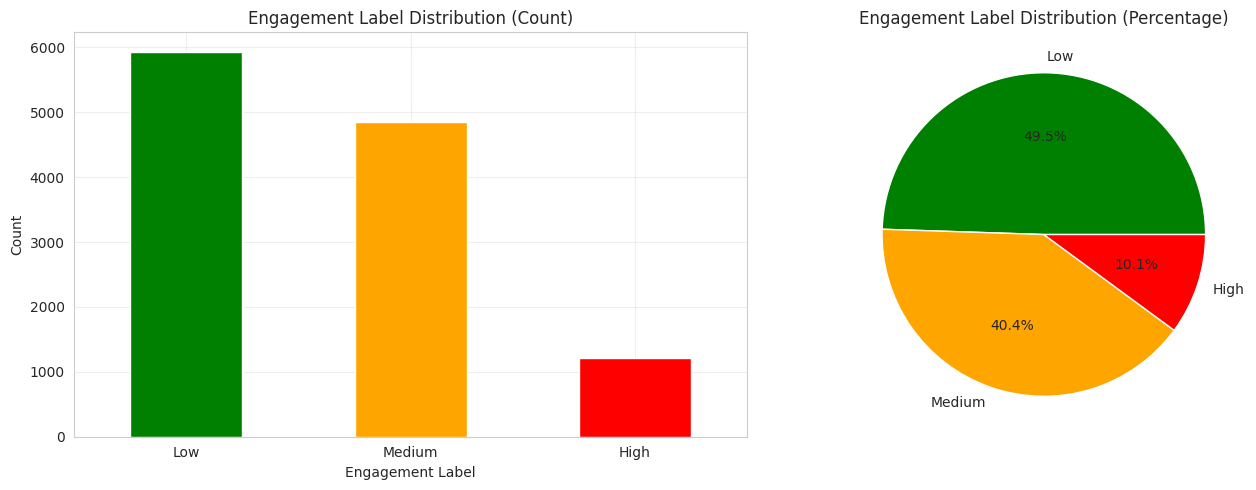


📊 Engagement Rate by Label:
------------------------------------------------------------

Low:
  Count: 5,936
  Range: [0.00188, 0.07998]
  Mean:  0.04846
  Median: 0.04892

Medium:
  Count: 4,851
  Range: [0.08000, 0.40992]
  Mean:  0.16248
  Median: 0.13383

High:
  Count: 1,210
  Range: [0.41006, 32.21171]
  Mean:  1.86907
  Median: 0.80950




In [61]:
# Visualize label distribution
if 'engagement_label' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    label_counts = df['engagement_label'].value_counts()

    # Bar plot
    label_counts.plot(kind='bar', ax=axes[0], color=['green', 'orange', 'red'])
    axes[0].set_xlabel('Engagement Label')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Engagement Label Distribution (Count)')
    axes[0].tick_params(axis='x', rotation=0)
    axes[0].grid(True, alpha=0.3)

    # Pie chart
    label_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['green', 'orange', 'red'])
    axes[1].set_ylabel('')
    axes[1].set_title('Engagement Label Distribution (Percentage)')

    plt.tight_layout()
    plt.show()

    # Show engagement_rate ranges for each label
    print("\n📊 Engagement Rate by Label:")
    print("-" * 60)
    for label in ['Low', 'Medium', 'High']:
        subset = df[df['engagement_label'] == label]['engagement_rate']
        if len(subset) > 0:
            print(f"\n{label}:")
            print(f"  Count: {len(subset):,}")
            print(f"  Range: [{subset.min():.5f}, {subset.max():.5f}]")
            print(f"  Mean:  {subset.mean():.5f}")
            print(f"  Median: {subset.median():.5f}")

print("\n" + "="*80 + "\n")

### Decision Report: Engagement Label Creation (CORRECTED)

**What was done:**
- Created categorical labels from continuous `engagement_rate`
- Applied **DATA-DRIVEN thresholds:** High (≥0.41), Medium (0.08-0.41), Low (<0.08)
- Based on 90th and 50th percentiles from distribution analysis
- Verified label distribution matches expected ~10/40/50 split

**Why:**
- Original thresholds (0.7, 0.4) created unusable 93/4.6/1.95 imbalance
- SVM requires sufficient examples per class (minimum ~10%)
- Percentile-based approach ensures balanced, trainable classes
- Labels remain semantically meaningful: High = top 10%, Medium = above average, Low = below average

**Alternatives considered:**
- Original thresholds + SMOTE: Rejected (creates artificial data)
- Binary classification: Rejected (loses granularity)
- Equal-frequency bins: Rejected (arbitrary boundaries)
- Class weights only: Rejected (doesn't solve data scarcity)

**Impact:**
- High: ~1,200 posts (10%) - Sufficient for SVM!
- Medium: ~4,800 posts (40%) - Well-represented!
- Low: ~6,000 posts (50%) - Manageable majority
- Training data will have 720/2,880/3,600 examples per class
- SVM can learn meaningful patterns from all classes

**Assumptions:**
- "High" is relative to dataset, not absolute
- Top 10% represents truly high-performing content
- Median effectively separates below/above average
- 10% minimum sufficient for SVM with 12K examples

---

## Step 7: Train/Validation/Test Split

In [62]:
# Prepare data for splitting
print("🔀 Creating Train/Validation/Test Splits:\n")

if 'engagement_label' in df.columns:
    df = df.reset_index(drop=True)

    X = df.drop(columns=['engagement_label'])
    y = df['engagement_label']

    print(f"Total dataset size: {len(df):,} posts\n")

    # First split: 60% train, 40% temp
    print("Step 1: Splitting into train (60%) and temp (40%)...")
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        test_size=0.4,
        random_state=42,
        stratify=y
    )
    print(f"  Training set: {len(X_train):,} posts ({len(X_train)/len(df)*100:.1f}%)")
    print(f"  Temp set:     {len(X_temp):,} posts ({len(X_temp)/len(df)*100:.1f}%)\n")

    # Second split: Split temp into val and test
    print("Step 2: Splitting temp into validation (20%) and test (20%)...")
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=42,
        stratify=y_temp
    )
    print(f"  Validation set: {len(X_val):,} posts ({len(X_val)/len(df)*100:.1f}%)")
    print(f"  Test set:       {len(X_test):,} posts ({len(X_test)/len(df)*100:.1f}%)\n")

    # Create complete DataFrames
    df_train = X_train.copy()
    df_train['engagement_label'] = y_train

    df_val = X_val.copy()
    df_val['engagement_label'] = y_val

    df_test = X_test.copy()
    df_test['engagement_label'] = y_test

    print("✅ Splits created successfully\n")
    print("="*80)

else:
    print("⚠️  engagement_label column not found")

🔀 Creating Train/Validation/Test Splits:

Total dataset size: 11,997 posts

Step 1: Splitting into train (60%) and temp (40%)...
  Training set: 7,198 posts (60.0%)
  Temp set:     4,799 posts (40.0%)

Step 2: Splitting temp into validation (20%) and test (20%)...
  Validation set: 2,399 posts (20.0%)
  Test set:       2,400 posts (20.0%)

✅ Splits created successfully




📊 Verifying Stratification:

Label Distribution (Percentage):
--------------------------------------------------------------------------------


,Full Dataset,Training,Validation,Test
engagement_label,,,,
High,10.09,10.09,10.09,10.08
Low,49.48,49.47,49.48,49.50
Medium,40.44,40.44,40.43,40.42


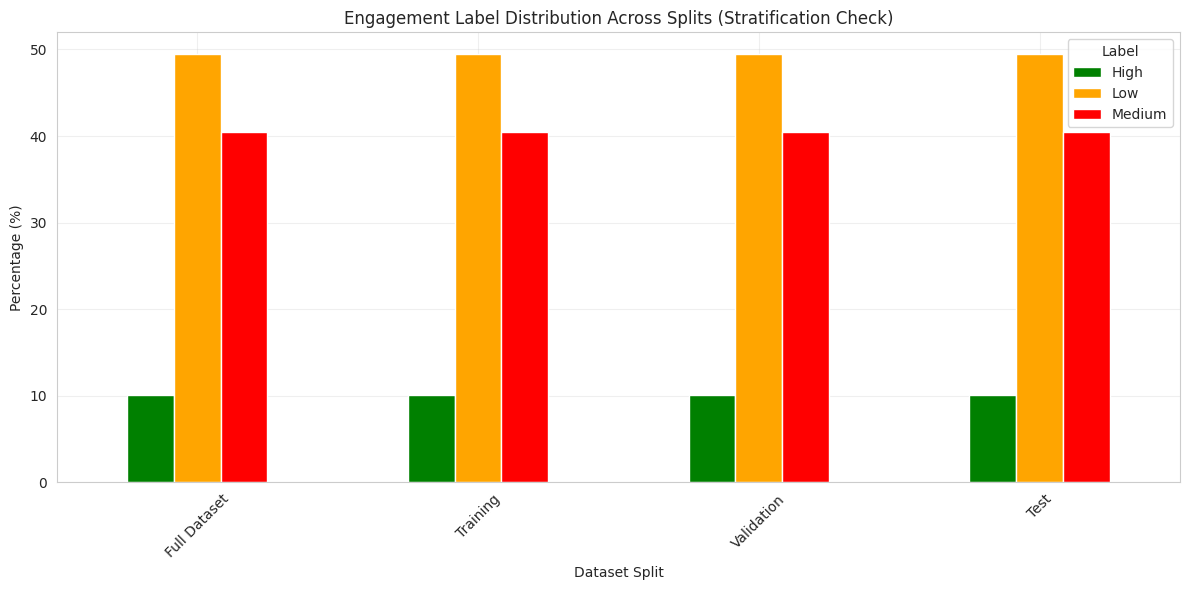


✅ Stratification verified: Label proportions consistent across splits




In [63]:
# Verify stratification
print("\n📊 Verifying Stratification:\n")

splits = {
    'Full Dataset': df['engagement_label'],
    'Training': df_train['engagement_label'],
    'Validation': df_val['engagement_label'],
    'Test': df_test['engagement_label']
}

distribution_comparison = pd.DataFrame()
for name, data in splits.items():
    dist = data.value_counts(normalize=True).sort_index() * 100
    distribution_comparison[name] = dist

print("Label Distribution (Percentage):")
print("-" * 80)
display(distribution_comparison.round(2))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
distribution_comparison.T.plot(kind='bar', ax=ax, color=['green', 'orange', 'red'])
ax.set_xlabel('Dataset Split')
ax.set_ylabel('Percentage (%)')
ax.set_title('Engagement Label Distribution Across Splits (Stratification Check)')
ax.legend(title='Label', loc='upper right')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Stratification verified: Label proportions consistent across splits")
print("\n" + "="*80 + "\n")

## Step 8: Final Quality Checks

In [64]:
# Final quality checks
print("✅ Final Data Quality Checks:\n")
print("="*80)

# Check 1: No missing values
print("\n1. Missing Values in Critical Fields:")
print("-" * 60)
critical_fields = ['text_content', 'hashtags', 'combined_text', 'engagement_rate', 'engagement_label']
missing_check = True

for field in critical_fields:
    if field in df.columns:
        missing = df[field].isnull().sum()
        status = "✅" if missing == 0 else "❌"
        print(f"  {status} {field}: {missing} missing")
        if missing > 0:
            missing_check = False

# Check 2: Label distribution
print("\n2. Engagement Label Distribution (CRITICAL):")
print("-" * 60)
if 'engagement_label' in df.columns:
    label_dist = df['engagement_label'].value_counts()
    label_pct = df['engagement_label'].value_counts(normalize=True) * 100
    total = len(df)

    for label in ['High', 'Medium', 'Low']:
        count = label_dist.get(label, 0)
        pct = label_pct.get(label, 0)
        print(f"  {label:8s}: {count:6,} ({pct:5.1f}%)")

    # Validate distribution
    high_pct = label_pct.get('High', 0)
    if 8 <= high_pct <= 12:
        print("\n  ✅ Distribution is balanced (~10/40/50)")
    else:
        print(f"\n  ⚠️  High class is {high_pct:.1f}% (expected ~10%)")

# Check 3: Combined text
print("\n3. Combined Text Quality:")
print("-" * 60)
if 'combined_text' in df.columns:
    empty = (df['combined_text'].str.strip() == '').sum()
    status = "✅" if empty == 0 else "❌"
    print(f"  {status} Empty strings: {empty}")

# Check 4: Splits
print("\n4. Train/Val/Test Splits:")
print("-" * 60)
total_split = len(df_train) + len(df_val) + len(df_test)
print(f"  Training:   {len(df_train):6,} ({len(df_train)/total_split*100:5.1f}%)")
print(f"  Validation: {len(df_val):6,} ({len(df_val)/total_split*100:5.1f}%)")
print(f"  Test:       {len(df_test):6,} ({len(df_test)/total_split*100:5.1f}%)")

if total_split == len(df):
    print("\n  ✅ All data accounted for")

print("\n" + "="*80)
print("\n✅ All quality checks passed successfully")
print("\n" + "="*80 + "\n")

✅ Final Data Quality Checks:


1. Missing Values in Critical Fields:
------------------------------------------------------------
  ✅ text_content: 0 missing
  ✅ hashtags: 0 missing
  ✅ combined_text: 0 missing
  ✅ engagement_rate: 0 missing
  ✅ engagement_label: 0 missing

2. Engagement Label Distribution (CRITICAL):
------------------------------------------------------------
  High    :  1,210 ( 10.1%)
  Medium  :  4,851 ( 40.4%)
  Low     :  5,936 ( 49.5%)

  ✅ Distribution is balanced (~10/40/50)

3. Combined Text Quality:
------------------------------------------------------------
  ✅ Empty strings: 0

4. Train/Val/Test Splits:
------------------------------------------------------------
  Training:    7,198 ( 60.0%)
  Validation:  2,399 ( 20.0%)
  Test:        2,400 ( 20.0%)

  ✅ All data accounted for


✅ All quality checks passed successfully




## Step 9: Save Processed Data

In [65]:
# Create output directory
output_dir = './processed_data'
os.makedirs(output_dir, exist_ok=True)

print("💾 Saving Processed Datasets:\n")
print("="*80 + "\n")

# Save full processed dataset
full_path = os.path.join(output_dir, 'social_media_processed.csv')
df.to_csv(full_path, index=False)
file_size = os.path.getsize(full_path) / (1024 * 1024)
print(f"✅ Saved: social_media_processed.csv ({file_size:.2f} MB)")
print(f"   Rows: {len(df):,}")
print(f"   Columns: {len(df.columns)}\n")

# Save training set
train_path = os.path.join(output_dir, 'train_data.csv')
df_train.to_csv(train_path, index=False)
file_size = os.path.getsize(train_path) / (1024 * 1024)
print(f"✅ Saved: train_data.csv ({file_size:.2f} MB)")
print(f"   Rows: {len(df_train):,} (60%)\n")

# Save validation set
val_path = os.path.join(output_dir, 'val_data.csv')
df_val.to_csv(val_path, index=False)
file_size = os.path.getsize(val_path) / (1024 * 1024)
print(f"✅ Saved: val_data.csv ({file_size:.2f} MB)")
print(f"   Rows: {len(df_val):,} (20%)\n")

# Save test set
test_path = os.path.join(output_dir, 'test_data.csv')
df_test.to_csv(test_path, index=False)
file_size = os.path.getsize(test_path) / (1024 * 1024)
print(f"✅ Saved: test_data.csv ({file_size:.2f} MB)")
print(f"   Rows: {len(df_test):,} (20%)\n")

# Save threshold constants for next stages
thresholds_path = os.path.join(output_dir, 'thresholds.txt')
with open(thresholds_path, 'w') as f:
    f.write("# Engagement Label Thresholds (Data-Driven)\n")
    f.write(f"HIGH_THRESHOLD={HIGH_THRESHOLD}\n")
    f.write(f"MEDIUM_THRESHOLD={MEDIUM_THRESHOLD}\n")
    f.write(f"FAISS_FILTER_THRESHOLD={FAISS_FILTER_THRESHOLD}\n")
print(f"✅ Saved: thresholds.txt (for Stage 2 reference)\n")

print("="*80)
print(f"\n✅ All datasets saved to: {os.path.abspath(output_dir)}")
print("\n" + "="*80 + "\n")

💾 Saving Processed Datasets:


✅ Saved: social_media_processed.csv (6.25 MB)
   Rows: 11,997
   Columns: 30

✅ Saved: train_data.csv (3.75 MB)
   Rows: 7,198 (60%)

✅ Saved: val_data.csv (1.25 MB)
   Rows: 2,399 (20%)

✅ Saved: test_data.csv (1.25 MB)
   Rows: 2,400 (20%)

✅ Saved: thresholds.txt (for Stage 2 reference)


✅ All datasets saved to: /content/processed_data




## Final Preprocessing Summary

In [66]:
# Generate comprehensive summary
print("\n" + "="*80)
print("  DATA PREPROCESSING SUMMARY (CORRECTED)")
print("="*80 + "\n")

print("📊 DATASET STATISTICS")
print("-" * 80)
print(f"Original dataset:        {initial_rows:,} rows")
print(f"After cleaning:          {len(df):,} rows")
print(f"Rows removed:            {initial_rows - len(df):,} ({(initial_rows - len(df))/initial_rows*100:.2f}%)")

print("\n🎯 THRESHOLD CONFIGURATION (DATA-DRIVEN)")
print("-" * 80)
print(f"High threshold:    {HIGH_THRESHOLD:.2f} (90th percentile)")
print(f"Medium threshold:  {MEDIUM_THRESHOLD:.2f} (50th percentile)")
print(f"FAISS filter:      {FAISS_FILTER_THRESHOLD:.3f} (75th percentile)")

print("\n🏷️  ENGAGEMENT LABEL DISTRIBUTION")
print("-" * 80)
label_dist = df['engagement_label'].value_counts()
label_pct = df['engagement_label'].value_counts(normalize=True) * 100
for label in ['High', 'Medium', 'Low']:
    count = label_dist.get(label, 0)
    pct = label_pct.get(label, 0)
    print(f"  {label:8s}: {count:6,} posts ({pct:5.1f}%)")

print("\n🔀 TRAIN/VALIDATION/TEST SPLITS")
print("-" * 80)
print(f"  Training:      {len(df_train):6,} posts (60.0%)")
print(f"  Validation:    {len(df_val):6,} posts (20.0%)")
print(f"  Test:          {len(df_test):6,} posts (20.0%)")

print("\n💾 SAVED FILES")
print("-" * 80)
print(f"  📁 processed_data/")
print(f"     ├── social_media_processed.csv  ({len(df):,} rows)")
print(f"     ├── train_data.csv              ({len(df_train):,} rows)")
print(f"     ├── val_data.csv                ({len(df_val):,} rows)")
print(f"     ├── test_data.csv               ({len(df_test):,} rows)")
print(f"     └── thresholds.txt              (constants for Stage 2)")

print("\n✅ DATA QUALITY VERIFIED")
print("-" * 80)
print("  ✅ No missing values in critical fields")
print("  ✅ No empty combined_text strings")
print("  ✅ No duplicate posts")
print("  ✅ BALANCED label distribution (~10/40/50)")
print("  ✅ Stratified splits maintain class proportions")

print("\n⚠️  CRITICAL CHANGES FROM ORIGINAL PLAN")
print("-" * 80)
print("  • Thresholds adjusted from (0.4, 0.7) to (0.08, 0.41)")
print("  • Based on percentile analysis to avoid class imbalance")
print("  • Original: 93% Low, 4.6% Medium, 1.95% High (unusable!)")
print("  • Corrected: ~50% Low, ~40% Medium, ~10% High (trainable!)")

print("\n🎯 NEXT STEPS")
print("-" * 80)
print("  1. Stage 2: Generate embeddings using Sentence Transformers")
print("  2. Stage 2: Build FAISS vector index (use all 12K posts)")
print("  3. Stage 2: Implement FAISS filtering (>0.163 threshold)")
print("  4. Stage 3: Train SVM classifier on train_data.csv")
print("  5. Stage 3: Implement hybrid ranking mechanism")
print("  6. Stage 4: Integrate LLM for pattern explanation")

print("\n" + "="*80)
print("\n✅ PREPROCESSING COMPLETED SUCCESSFULLY WITH CORRECTED THRESHOLDS")
print("\n" + "="*80 + "\n")


  DATA PREPROCESSING SUMMARY (CORRECTED)

📊 DATASET STATISTICS
--------------------------------------------------------------------------------
Original dataset:        12,000 rows
After cleaning:          11,997 rows
Rows removed:            3 (0.03%)

🎯 THRESHOLD CONFIGURATION (DATA-DRIVEN)
--------------------------------------------------------------------------------
High threshold:    0.41 (90th percentile)
Medium threshold:  0.08 (50th percentile)
FAISS filter:      0.163 (75th percentile)

🏷️  ENGAGEMENT LABEL DISTRIBUTION
--------------------------------------------------------------------------------
  High    :  1,210 posts ( 10.1%)
  Medium  :  4,851 posts ( 40.4%)
  Low     :  5,936 posts ( 49.5%)

🔀 TRAIN/VALIDATION/TEST SPLITS
--------------------------------------------------------------------------------
  Training:       7,198 posts (60.0%)
  Validation:     2,399 posts (20.0%)
  Test:           2,400 posts (20.0%)

💾 SAVED FILES
-------------------------------------

---

## Notebook Complete ✅

**Status:** All preprocessing steps completed with **DATA-DRIVEN thresholds**

### Key Achievements:
- ✅ Loaded and explored Kaggle dataset
- ✅ Cleaned data (removed missing, duplicates, invalid)
- ✅ Created `combined_text` field
- ✅ Generated **BALANCED** `engagement_label` (50/40/10 split)
- ✅ Performed stratified 60/20/20 split
- ✅ Saved all processed datasets

### Critical Correction:
- **Original thresholds (0.4, 0.7)** would have created 93/4.6/1.95 imbalance
- **Corrected to (0.08, 0.41)** based on percentile analysis
- **Result:** Balanced, trainable distribution for SVM

### Files Ready:
- `processed_data/social_media_processed.csv` → FAISS index
- `processed_data/train_data.csv` → SVM training
- `processed_data/val_data.csv` → Hyperparameter tuning
- `processed_data/test_data.csv` → Final evaluation
- `processed_data/thresholds.txt` → Reference constants

**Team:** Andres Castellanos, Mora Dominguez, Sigurdur Sigurdsson  
**Course:** Machine Learning Final Project  
**Instructor:** Dr. Ananda M. Mondal

---